In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim
import gym
from gym import spaces

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class ShortPeriodAircraftContinuousEnv(gym.Env):
    def __init__(self):
        super().__init__()

        # Short-Period Dynamics
        self.A = np.array([
            [-11.0104, -2.3366],
            [-1.4787,   0.9757]
        ])
        self.B = np.array([-0.1501, -18.3881])
        self.dt = 0.02  # [s] simulation time step

        # Observation space: [delta_q, delta_e]
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -0.25], dtype=np.float32),
            high=np.array([1.0,  0.25], dtype=np.float32),
            dtype=np.float32
        )

        # Action space: unscaled delta(delta_e), normalized later
        self.max_delta_change = 0.002  # (not used anymore by agent, but kept for clipping)
        self.action_space = spaces.Box(
            low=np.array([-self.max_delta_change], dtype=np.float32),
            high=np.array([self.max_delta_change], dtype=np.float32),
            dtype=np.float32
        )

        self.alpha = 0.0
        self.q = 0.0
        self.prev_delta_e = 0.0
        self.current_step = 0
        self.max_steps = 2000

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.alpha = 0.0
        self.q = 0.0
        self.prev_delta_e = 0.0
        self.current_step = 0

        q_ref = 0.15 * np.sin(2 * np.pi * 0.15 * self.current_step * self.dt)
        delta_q = self.q - q_ref

        delta_e = self.prev_delta_e  # which is 0
        obs = np.array([delta_q, delta_e], dtype=np.float32)
        return obs, {}

    def step(self, delta_e):
        """
        Expects 'delta_e' directly (already integrated and clipped in main loop).
        """

        # 1) Clip delta_e again, just to be safe
        delta_e = np.clip(delta_e, -0.25, 0.25)
        self.prev_delta_e = delta_e

        # 2) Dynamics
        q_ref = 0.15 * np.sin(2 * np.pi * 0.15 * self.current_step * self.dt)
        state_dot = self.A @ np.array([self.alpha, self.q]) + self.B * delta_e

        self.alpha += state_dot[0] * self.dt
        self.q     += state_dot[1] * self.dt

        self.alpha = np.clip(self.alpha, -1.0, 1.0)
        self.q     = np.clip(self.q, -1.0, 1.0)

        self.current_step += 1

        # 3) New observation
        delta_q = self.q - q_ref
        obs = np.array([delta_q, delta_e], dtype=np.float32)

        # 4) Reward
        Q_q = 10.0  # Pitch rate tracking importance
        R = 1.0    # Elevator deflection magnitude penalty
        reward = -(Q_q * delta_q**2 + R * delta_e**2)


        # 5) Termination
        terminated = bool((abs(self.alpha) > 2.0) or (abs(self.q) > 2.0))
        truncated  = bool(self.current_step >= self.max_steps)

        info = {
            "q_ref": q_ref,
            "delta_q": delta_q,
            "q": self.q,
            "delta_e": delta_e
        }

        return obs, reward, terminated, truncated, info


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_sizes=[128, 64], final_gain=0.01):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], action_size)

        # Apply orthogonal initialization
        self.apply(lambda m: self.orthogonal_init(m, final_gain=final_gain))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Assumes actions scaled to [-1, 1]
        return x

    @staticmethod
    def orthogonal_init(layer, gain=1.0, final_gain=0.01):
        if isinstance(layer, nn.Linear):
            if layer.out_features == 1 or layer.out_features < 10:
                torch.nn.init.orthogonal_(layer.weight, gain=final_gain)
            else:
                torch.nn.init.orthogonal_(layer.weight, gain=gain)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_sizes=[128, 64], final_gain=0.01):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # State and action go together in the second layer
        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0] + action_size, hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 1)

        # Apply orthogonal initialization
        self.apply(lambda m: self.orthogonal_init(m, final_gain=final_gain))

    def forward(self, state, action):
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)  # Concatenate along features
        x = F.relu(self.fc2(x))
        q = self.fc3(x)  # Output Q-value
        return q

    @staticmethod
    def orthogonal_init(layer, gain=1.0, final_gain=0.01):
        if isinstance(layer, nn.Linear):
            if layer.out_features == 1 or layer.out_features < 10:
                torch.nn.init.orthogonal_(layer.weight, gain=final_gain)
            else:
                torch.nn.init.orthogonal_(layer.weight, gain=gain)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)




In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.learn_step = 0
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)


        # Actor Network (w/ Target Network)
        self.critic_local_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_local_2 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_2 = Critic(state_size, action_size, random_seed).to(device)

        self.critic_optimizer_1 = optim.Adam(self.critic_local_1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic_optimizer_2 = optim.Adam(self.critic_local_2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)


        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and learn from sample"""
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using a batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- Update Critics ---------------------------- #
        # Target actions with clipped noise
        actions_next = self.actor_target(next_states)
        noise = (torch.randn_like(actions_next) * POLICY_NOISE).clamp(-NOISE_CLIP, NOISE_CLIP)
        actions_next = (actions_next + noise).clamp(-1, 1)

        # Target Q values from two critics
        Q_target1_next = self.critic_target_1(next_states, actions_next)
        Q_target2_next = self.critic_target_2(next_states, actions_next)
        Q_targets_next = torch.min(Q_target1_next, Q_target2_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Current Q estimates
        Q_expected1 = self.critic_local_1(states, actions)
        Q_expected2 = self.critic_local_2(states, actions)

        # Critic losses
        critic_loss1 = F.mse_loss(Q_expected1, Q_targets.detach())
        critic_loss2 = F.mse_loss(Q_expected2, Q_targets.detach())

        # Update critics
        self.critic_optimizer_1.zero_grad()
        critic_loss1.backward()
        self.critic_optimizer_1.step()

        self.critic_optimizer_2.zero_grad()
        critic_loss2.backward()
        self.critic_optimizer_2.step()

        # ---------------------------- Delayed Actor Update ---------------------------- #
        self.learn_step += 1
        if self.learn_step % POLICY_DELAY == 0:
            # Actor loss (maximize Q estimate)
            actions_pred = self.actor_local(states)
            actor_loss = -self.critic_local_1(states, actions_pred).mean()

            # Update actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft updates for all targets
            self.soft_update(self.critic_local_1, self.critic_target_1, TAU)
            self.soft_update(self.critic_local_2, self.critic_target_2, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)


    #  previous act function that took into account delta_e, instead of delta_delta_e, which is what we now use

    # def act(self, states, add_noise=True):
    #     """Returns actions for given state as per current policy."""
    #     states = torch.from_numpy(states).float().to(device)
    #     #self.actor_local.eval()
    #     with torch.no_grad():
    #         actions = self.actor_local(states).cpu().data.numpy()
    #     #self.actor_local.train()
    #     if add_noise:
    #         actions += np.random.normal(0, ACT_NOISE, size=actions.shape)
    #     return np.clip(actions, -1, 1)

    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        with torch.no_grad():
            delta_action = self.actor_local(states).cpu().data.numpy()
        if add_noise:
            delta_action += np.random.normal(0, ACT_NOISE, size=delta_action.shape)
        return np.clip(delta_action, -1, 1)  # Still unscaled


    def reset(self):
        pass

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class AgentCAPS_TD3():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.learn_step = 0
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_local_2 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_2 = Critic(state_size, action_size, random_seed).to(device)

        self.critic_optimizer_1 = optim.Adam(self.critic_local_1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic_optimizer_2 = optim.Adam(self.critic_local_2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        # self.lambda_t = 5e-3
        # self.lambda_s = 1e-3
        self.lambda_t = 1e-3
        self.lambda_s = 5e-2

    def step(self, states, actions, rewards, next_states, dones):
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            noise = (torch.randn_like(actions_next) * POLICY_NOISE).clamp(-NOISE_CLIP, NOISE_CLIP)
            actions_next = (actions_next + noise).clamp(-1, 1)

            Q_target1_next = self.critic_target_1(next_states, actions_next)
            Q_target2_next = self.critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_target1_next, Q_target2_next)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected1 = self.critic_local_1(states, actions)
        Q_expected2 = self.critic_local_2(states, actions)

        critic_loss1 = F.mse_loss(Q_expected1, Q_targets)
        critic_loss2 = F.mse_loss(Q_expected2, Q_targets)

        self.critic_optimizer_1.zero_grad()
        critic_loss1.backward()
        self.critic_optimizer_1.step()

        self.critic_optimizer_2.zero_grad()
        critic_loss2.backward()
        self.critic_optimizer_2.step()

        self.learn_step += 1
        if self.learn_step % POLICY_DELAY == 0:
            actions_pred = self.actor_local(states)
            actor_loss = -self.critic_local_1(states, actions_pred).mean()

            # CAPS temporal smoothness
            actions_pred_next = self.actor_local(next_states)
            temporal_loss = F.mse_loss(actions_pred_next, actions_pred)

            # CAPS spatial consistency
            noise = torch.normal(mean=0.0, std=0.01, size=states.shape).to(device)
            perturbed_states = states + noise
            actions_perturbed = self.actor_local(perturbed_states)
            spatial_loss = F.mse_loss(actions_pred, actions_perturbed)

            # Total actor loss with CAPS
            actor_loss += self.lambda_t * temporal_loss + self.lambda_s * spatial_loss

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            self.soft_update(self.critic_local_1, self.critic_target_1, TAU)
            self.soft_update(self.critic_local_2, self.critic_target_2, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)

    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        if add_noise:
            actions += np.random.normal(0, ACT_NOISE, size=actions.shape)
        return np.clip(actions, -1, 1)

    def reset(self):
        pass

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)


In [14]:

def scale_action(delta_action, max_rate=0.1):
    """
    Scale delta_action from [-1, 1] to physical actuator rate limits in rad/s.
    """
    return np.clip(delta_action, -1.0, 1.0) * max_rate

def TD3(n_episodes=200, max_t=2000, print_every=1):
    scores = []
    scores_deque = deque(maxlen=print_every)

    best_reward = -np.inf
    best_q_vals = []
    best_q_refs = []
    best_delta_qs = []
    best_delta_es = []

    good_episode_streak = 0

    try:
        for i_episode in range(1, n_episodes + 1):
            obs, info = env.reset()
            state = obs  # state = [delta_q, prev_delta_e]

            agent.reset()
            total_reward = 0

            episode_q_vals = []
            episode_q_refs = []
            episode_delta_qs = []
            episode_delta_es = []
            steps_run = 0

            prev_delta_e = 0.0  # Start from zero elevator deflection

            for t in range(max_t):
                steps_run += 1

                # 1. Act
                state = np.array(state, dtype=np.float32).reshape(1, -1)
                delta_action = agent.act(state)  # Output is raw delta(delta_e) ∈ [-1, 1]

                # 2. Scale and integrate
                delta_rate = scale_action(delta_action, max_rate=0.1).flatten()[0]  # rad/s
                delta_e = prev_delta_e + delta_rate * env.dt  # integrate over dt=0.02s
                delta_e = np.clip(delta_e, -0.25, 0.25)  # Clamp total deflection
                prev_delta_e = delta_e  # Update memory

                # 3. Step environment
                next_obs, reward, terminated, truncated, info = env.step(delta_e)
                done = terminated or truncated

                # 4. Extract and build next state
                q = info.get("q", 0.0)
                q_ref = info.get("q_ref", 0.0)
                delta_q = info.get("delta_q", 0.0)

                episode_q_vals.append(q)
                episode_q_refs.append(q_ref)
                episode_delta_qs.append(delta_q)
                episode_delta_es.append(delta_e)

                next_state = np.array([delta_q, delta_e], dtype=np.float32)

                # 5. Store experience
                agent.step(np.array([state]), np.array([delta_action]), np.array([reward]),
                           np.array([next_state]), np.array([done]))

                # 6. Update loop
                state = next_state
                total_reward += reward

                if done:
                    break

            scores.append(total_reward)
            scores_deque.append(total_reward)
            avg_reward = np.mean(scores_deque) if len(scores_deque) > 0 else total_reward
            print(f"\rEpisode {i_episode}/{n_episodes}\tSteps: {steps_run}\tReward: {total_reward:.2f}\tAverage Reward: {avg_reward:.2f}", end="")
            if i_episode % print_every == 0:
                print("")

            # Save best full-length episode
            if t == max_t - 1 and total_reward > best_reward:
                best_reward = total_reward
                best_q_vals = episode_q_vals.copy()
                best_q_refs = episode_q_refs.copy()
                best_delta_qs = episode_delta_qs.copy()
                best_delta_es = episode_delta_es.copy()

            # Early stopping
            if not done and total_reward > -1:
                good_episode_streak += 1
            else:
                good_episode_streak = 0

            if good_episode_streak >= 5:
                print(f"\nEarly stopping after {i_episode} episodes — 5 consecutive good full-length episodes.")
                break

    except KeyboardInterrupt:
        print(f"\nTraining manually interrupted at episode {i_episode}.")

    return scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward


Episode 1/200	Steps: 2000	Reward: -18145.73	Average Reward: -18145.73
Episode 2/200	Steps: 2000	Reward: -17911.55	Average Reward: -17911.55
Episode 3/200	Steps: 2000	Reward: -18728.63	Average Reward: -18728.63
Episode 4/200	Steps: 2000	Reward: -18169.37	Average Reward: -18169.37
Episode 5/200	Steps: 2000	Reward: -19672.42	Average Reward: -19672.42
Episode 6/200	Steps: 2000	Reward: -19485.62	Average Reward: -19485.62
Episode 7/200	Steps: 2000	Reward: -19260.22	Average Reward: -19260.22
Episode 8/200	Steps: 2000	Reward: -19337.26	Average Reward: -19337.26
Episode 9/200	Steps: 2000	Reward: -16533.42	Average Reward: -16533.42
Episode 10/200	Steps: 2000	Reward: -18455.54	Average Reward: -18455.54
Episode 11/200	Steps: 2000	Reward: -18362.01	Average Reward: -18362.01
Episode 12/200	Steps: 2000	Reward: -18194.10	Average Reward: -18194.10
Episode 13/200	Steps: 2000	Reward: -17097.61	Average Reward: -17097.61
Episode 14/200	Steps: 2000	Reward: -18416.64	Average Reward: -18416.64
Episode 15/200	

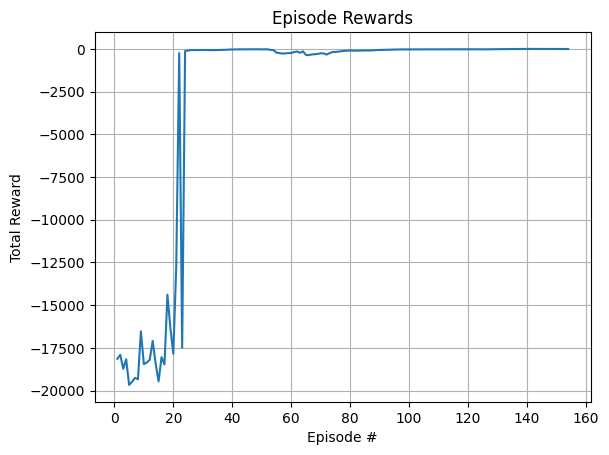

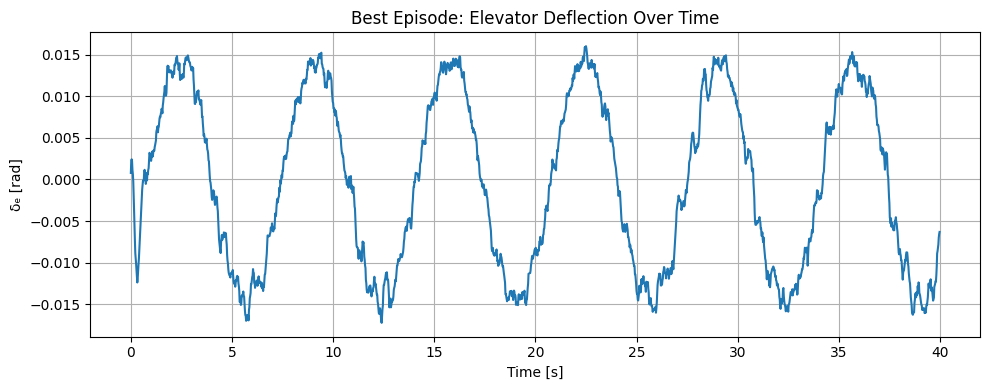

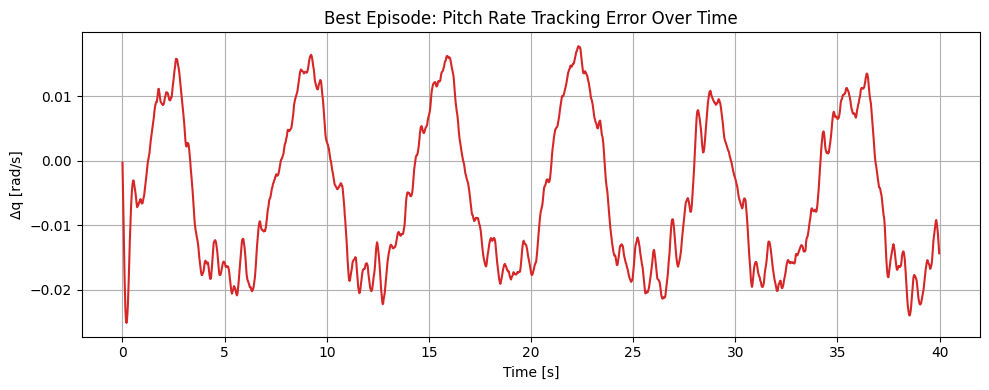

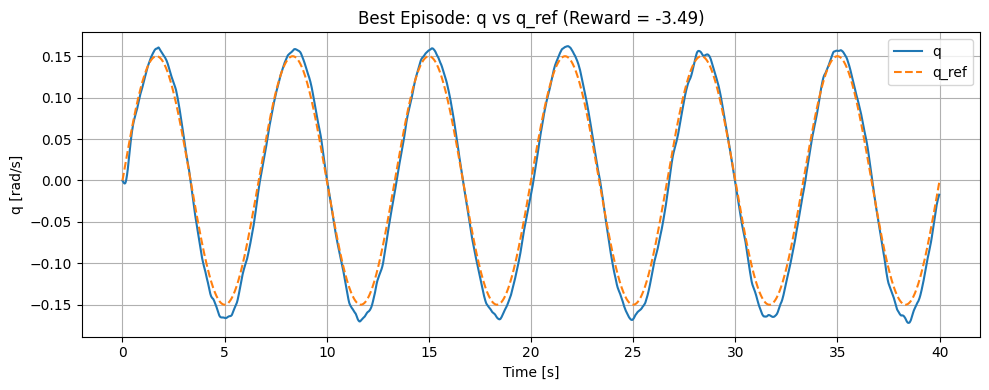

In [ ]:

# Parameters for TD3 + CAPS
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.97             # discount factor (or 0.98 if long horizons needed)
TAU = 5e-4               # target network soft update (or 1e-3 if faster updates needed)
LR_ACTOR = 1e-4          # actor learning rate
LR_CRITIC = 1e-3         # critic learning rate (NOT 5e-3!)
WEIGHT_DECAY = 0         # no L2 regularization
POLICY_NOISE = 0.3       # TD3 target policy noise
NOISE_CLIP = 0.5         # clip noise
POLICY_DELAY = 2         # update actor every 2 critic updates
ACT_NOISE = 0.2         # smaller exploration noise for incremental control




env = ShortPeriodAircraftContinuousEnv()
state_size = env.observation_space.shape[0]  # or just 1
action_size = env.action_space.shape[0]      # or just 1

# agent = Agent(state_size, action_size, num_agents=1, random_seed=120)
agent = AgentCAPS_TD3(state_size, action_size, num_agents=1, random_seed=120)


# We call the TD3 function, and we start learning:

scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward = TD3()



import matplotlib.pyplot as plt
import numpy as np
# Plot score curve
plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Episode #")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.grid()

best_idx = np.argmax(scores)

dt = 0.02  # Time step
timesteps = np.arange(len(best_delta_es)) * dt
import matplotlib.pyplot as plt
import numpy as np
# 1. Elevator deflection over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_es, label="Elevator Deflection (δₑ)", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("δₑ [rad]")
plt.title("Best Episode: Elevator Deflection Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Tracking error (delta_q) over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_qs, label="Tracking Error (Δq = q - q_ref)", color="tab:red")
plt.xlabel("Time [s]")
plt.ylabel("Δq [rad/s]")
plt.title("Best Episode: Pitch Rate Tracking Error Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_q_vals, label="q", linewidth=1.5)
plt.plot(timesteps, best_q_refs, label="q_ref", linestyle="--", linewidth=1.5)
plt.xlabel("Time [s]")
plt.ylabel("q [rad/s]")
plt.title(f"Best Episode: q vs q_ref (Reward = {best_reward:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Episode 1/200	Steps: 2000	Reward: -18054.53	Average Reward: -18054.53
Episode 2/200	Steps: 2000	Reward: -19459.26	Average Reward: -19459.26
Episode 3/200	Steps: 2000	Reward: -19598.50	Average Reward: -19598.50
Episode 4/200	Steps: 2000	Reward: -19516.87	Average Reward: -19516.87
Episode 5/200	Steps: 2000	Reward: -19411.39	Average Reward: -19411.39
Episode 6/200	Steps: 2000	Reward: -19403.38	Average Reward: -19403.38
Episode 7/200	Steps: 2000	Reward: -18794.81	Average Reward: -18794.81
Episode 8/200	Steps: 2000	Reward: -19201.82	Average Reward: -19201.82
Episode 9/200	Steps: 2000	Reward: -16173.05	Average Reward: -16173.05
Episode 10/200	Steps: 2000	Reward: -18037.32	Average Reward: -18037.32
Episode 11/200	Steps: 2000	Reward: -15145.91	Average Reward: -15145.91
Episode 12/200	Steps: 2000	Reward: -19849.42	Average Reward: -19849.42
Episode 13/200	Steps: 2000	Reward: -19910.75	Average Reward: -19910.75
Episode 14/200	Steps: 2000	Reward: -19753.70	Average Reward: -19753.70
Episode 15/200	

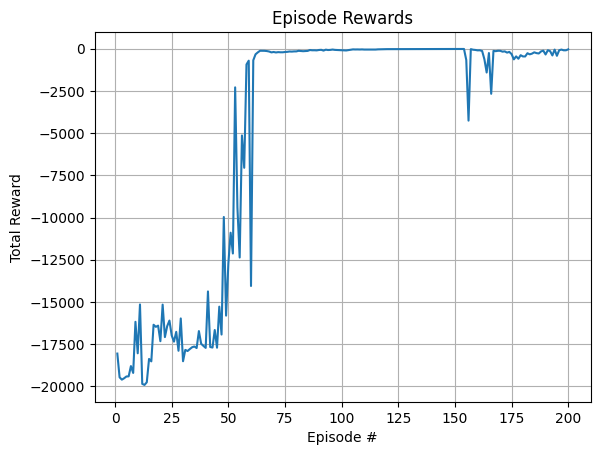

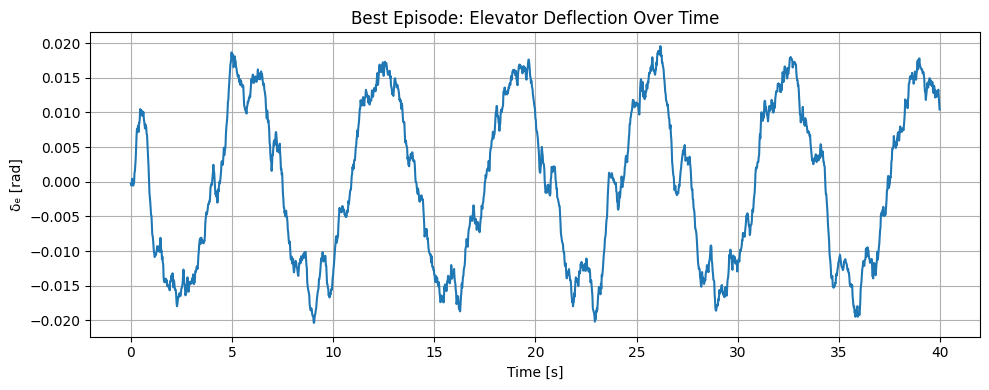

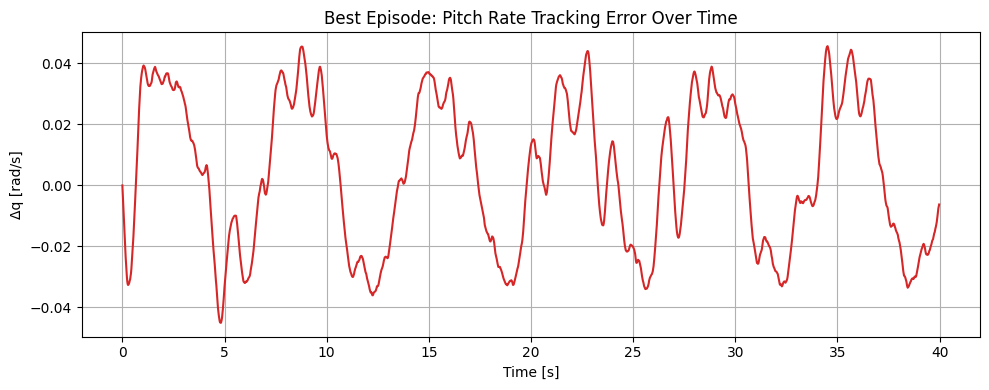

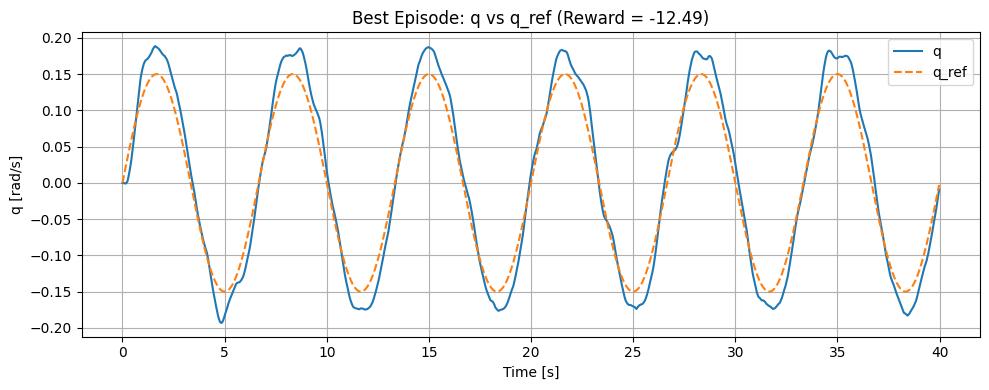

In [16]:


# Parameters for TD3 + CAPS
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.97             # discount factor (or 0.98 if long horizons needed)
TAU = 1e-3               # target network soft update (or 1e-3 if faster updates needed)
LR_ACTOR = 1e-4          # actor learning rate
LR_CRITIC = 1e-3         # critic learning rate (NOT 5e-3!)
WEIGHT_DECAY = 0         # no L2 regularization
POLICY_NOISE = 0.3       # TD3 target policy noise
NOISE_CLIP = 0.5         # clip noise
POLICY_DELAY = 5         # update actor every 2 critic updates
ACT_NOISE = 0.3         # smaller exploration noise for incremental control




env = ShortPeriodAircraftContinuousEnv()
state_size = env.observation_space.shape[0]  # or just 1
action_size = env.action_space.shape[0]      # or just 1

# agent = Agent(state_size, action_size, num_agents=1, random_seed=120)
agent = AgentCAPS_TD3(state_size, action_size, num_agents=1, random_seed=1260)


# We call the TD3 function, and we start learning:

scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward = TD3()

import matplotlib.pyplot as plt
import numpy as np
# Plot score curve
plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Episode #")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.grid()

best_idx = np.argmax(scores)

dt = 0.02  # Time step
timesteps = np.arange(len(best_delta_es)) * dt

for i in range(len(best_delta_es)):
    best_delta_es[i] = best_delta_es[i] * -1


import matplotlib.pyplot as plt
import numpy as np
# 1. Elevator deflection over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_es, label="Elevator Deflection (δₑ)", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("δₑ [rad]")
plt.title("Best Episode: Elevator Deflection Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Tracking error (delta_q) over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_qs, label="Tracking Error (Δq = q - q_ref)", color="tab:red")
plt.xlabel("Time [s]")
plt.ylabel("Δq [rad/s]")
plt.title("Best Episode: Pitch Rate Tracking Error Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_q_vals, label="q", linewidth=1.5)
plt.plot(timesteps, best_q_refs, label="q_ref", linestyle="--", linewidth=1.5)
plt.xlabel("Time [s]")
plt.ylabel("q [rad/s]")
plt.title(f"Best Episode: q vs q_ref (Reward = {best_reward:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()